In [1]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns',50)

In [2]:
class preprocess_data: 
    def __init__(self, data_path : Path) :
        self.data_path = data_path
        self.datetime_column = 'Dt_Customer'
        self.categorical_columns = ['Year_Birth' , 'Education', 'Marital_Status',
                            'Income', 'Kidhome', 'Teenhome','Recency', 'month','day','year']
        self.drop_columns = ['id', self.datetime_column] + self.categorical_columns
    
    def load_data(self) -> [pd.DataFrame, pd.DataFrame]:
        self.train = pd.read_csv(Path(self.data_path, Path('train.csv')))
        self.test = pd.read_csv(Path(self.data_path, Path('test.csv')))
        
    def preprocess_date(self) -> [pd.DataFrame, pd.DataFrame] : 
        self.train = self.date_features(self.train, self.datetime_column)
        self.test = self.date_features(self.test, self.datetime_column)

    def date_features(self, df, column) -> pd.DataFrame : 
        df[column] = pd.to_datetime(df[column], format = '%d-%m-%Y')
        df['year'] = df[column].apply(lambda x : x.year)
        df['month'] = df[column].apply(lambda x : x.month)
        df['day'] = df[column].apply(lambda x : x.day)
        return df


    def preprocess_categorical(self) -> [pd.DataFrame, pd.DataFrame] : 
        
        encoder = OneHotEncoder(max_categories=5, handle_unknown='ignore')
        train_oh = encoder.fit_transform(self.train[self.categorical_columns])
        test_oh = encoder.transform(self.test[self.categorical_columns])

        columns = encoder.get_feature_names_out(self.categorical_columns)
        train_oh = pd.DataFrame(train_oh.toarray(), columns = columns)
        test_oh = pd.DataFrame(test_oh.toarray(), columns = columns)

        self.train = pd.concat([self.train, train_oh], axis = 1)
        self.test = pd.concat([self.test, test_oh], axis = 1)


    def preprocess(self) :  
        self.load_data()
        self.preprocess_date()
        self.preprocess_categorical()
        self.train.drop(columns = self.drop_columns, inplace = True)        
        self.test.drop(columns = self.drop_columns, inplace = True)        
        return self.train, self.test


In [3]:
data_path = Path('./data')
preprocessor = preprocess_data(data_path)
train, test = preprocessor.preprocess()

# Modeling

### Hold-out

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_idx, valid_idx = train_test_split(train.index, shuffle = True, random_state = 0)
X_train = train.iloc[train_idx].drop(columns = ['target'])
X_valid = train.iloc[valid_idx].drop(columns = ['target'])
y_train = train['target'].iloc[train_idx]
y_valid = train['target'].iloc[valid_idx]

### Modeling

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [15]:
model  = RandomForestRegressor(n_estimators = 30)
model.fit(X_train, y_train)
pred = model.predict(X_valid)
mean_absolute_error(y_valid, pred)

144.7116633239738

## Explain

In [16]:
from sklearn.inspection import plot_partial_dependence, partial_dependence, PartialDependenceDisplay
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')
matplotlib.rcParams['figure.dpi'] = 100

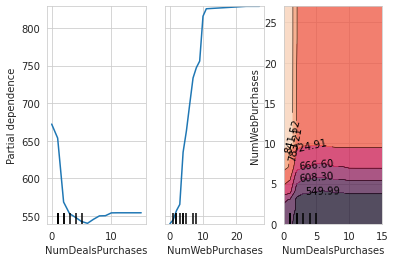

In [28]:
features = [0, 1,(0, 1)]
PartialDependenceDisplay.from_estimator(model, X_train, features)
plt.show()